<a href="https://colab.research.google.com/github/seawavve/PeekABook/blob/main/model/tensorflow_rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

In [8]:

data=pd.read_csv('./Peterpan_emo3.csv')
data=data.dropna(how='any')
print(f'Dimensions: {data.shape}')
data

Dimensions: (1697, 4)


,Unnamed: 0,sentence,posNeg,posNeg3
0,0,Chapter 1 PETER BREAKS THROUGH,0.000000,1.0
1,1,"All children, except one, grow up. They soon k...",0.311111,2.0
2,2,Of course they lived at 14 [their house number...,0.279545,2.0
3,3,The way Mr. Darling won her was this: the many...,0.483333,2.0
4,4,Mr. Darling used to boast to Wendy that her mo...,0.148889,1.0
...,...,...,...,...
1692,1692,"“If only I could go with you,” Wendy sighed.",0.000000,1.0
1693,1693,"“You see you can't fly,” said Jane.",0.800000,2.0
1694,1694,Of course in the end Wendy let them fly away t...,0.183333,2.0
1695,1695,"As you look at Wendy, you may see her hair bec...",0.097396,1.0


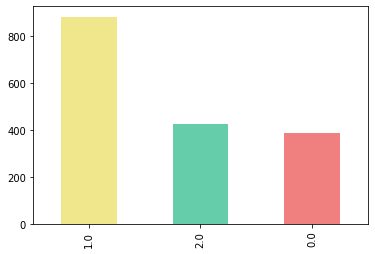

In [9]:
colors = ['khaki','mediumaquamarine','lightcoral']
data['posNeg3'].value_counts().plot(kind='bar',color=colors)


In [14]:
x_data = data['sentence']
y_data = data['posNeg3']
print('메일 본문의 개수: {}'.format(len(x_data)))
print('레이블의 개수: {}'.format(len(y_data)))

메일 본문의 개수: 1697
레이블의 개수: 1697


In [17]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_data) #X의 각 행에 토큰화를 수행
sequences = tokenizer.texts_to_sequences(x_data) # 단어를 숫자값, 인덱스로 변환하여 저장

In [18]:
sequences[:5]

[[345, 1717, 23, 1718, 129],
 [33,
  76,
  319,
  40,
  611,
  46,
  13,
  216,
  77,
  11,
  13,
  83,
  611,
  46,
  3,
  1,
  80,
  29,
  94,
  6,
  39,
  40,
  222,
  43,
  12,
  6,
  154,
  882,
  244,
  12,
  6,
  479,
  10,
  7,
  2609,
  3,
  12,
  1719,
  200,
  1295,
  3,
  346,
  27,
  9,
  4,
  16,
  81,
  31,
  522,
  12,
  107,
  32,
  193,
  161,
  1057,
  19,
  90,
  65,
  165,
  16,
  113,
  4,
  16,
  331,
  3,
  54,
  157,
  292,
  237,
  18,
  1058,
  75,
  39,
  19,
  131,
  2,
  39,
  6,
  33,
  11,
  404,
  426,
  30,
  22,
  1,
  1059,
  17,
  1720,
  29,
  94,
  11,
  12,
  107,
  611,
  46,
  18,
  120,
  77,
  122,
  18,
  41,
  154,
  154,
  25,
  1,
  679,
  8,
  1,
  320],
 [8,
  95,
  13,
  612,
  28,
  1296,
  37,
  135,
  1297,
  22,
  37,
  613,
  3,
  293,
  29,
  89,
  16,
  81,
  6,
  1,
  1060,
  40,
  12,
  6,
  7,
  321,
  210,
  27,
  7,
  1061,
  322,
  3,
  108,
  7,
  405,
  1062,
  223,
  16,
  1061,
  322,
  6,
  75,
  1,
  883,
  2610,
  4

In [19]:
word_to_index = tokenizer.word_index
vocab_size = len(word_to_index) + 1
print(word_to_index)

{'the': 1, '”': 2, 'and': 3, 'to': 4, 'he': 5, 'was': 6, 'a': 7, 'of': 8, 'it': 9, 'in': 10, 'that': 11, 'she': 12, 'they': 13, 'had': 14, 'his': 15, 'her': 16, 'but': 17, 'you': 18, 'for': 19, 'not': 20, 'said': 21, 'on': 22, 'peter': 23, 'him': 24, 'is': 25, 'as': 26, 'with': 27, 'at': 28, 'wendy': 29, 'them': 30, 'i': 31, 'have': 32, 'all': 33, 'were': 34, 'be': 35, 'so': 36, 'their': 37, 'would': 38, 'this': 39, 'one': 40, 'are': 41, 'there': 42, 'when': 43, 'by': 44, 'out': 45, 'up': 46, 'no': 47, '“i': 48, 'now': 49, 'hook': 50, 'we': 51, 'could': 52, 'if': 53, 'cried': 54, 'been': 55, 'then': 56, 'from': 57, 'who': 58, 'what': 59, 'time': 60, 'did': 61, 'which': 62, 'john': 63, 'do': 64, 'darling': 65, 'about': 66, 'me': 67, 'see': 68, 'little': 69, 'into': 70, 'boys': 71, 'an': 72, 'michael': 73, 'again': 74, 'like': 75, 'children': 76, 'know': 77, 'only': 78, 'night': 79, 'way': 80, 'mother': 81, 'first': 82, 'will': 83, 'never': 84, 'more': 85, 'thought': 86, 'just': 87, 'go'

In [20]:
threshold = 2
total_cnt = len(word_to_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합(vocabulary)에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

등장 빈도가 1번 이하인 희귀 단어의 수: 2658
단어 집합(vocabulary)에서 희귀 단어의 비율: 50.47474363843525
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.426372414919462


In [21]:
n_of_train = int(len(sequences) * 0.8)
n_of_test = int(len(sequences) - n_of_train)
print('훈련 데이터의 개수 :',n_of_train)
print('테스트 데이터의 개수:',n_of_test)

훈련 데이터의 개수 : 1357
테스트 데이터의 개수: 340


메일의 최대 길이 : 362
메일의 평균 길이 : 28.864467


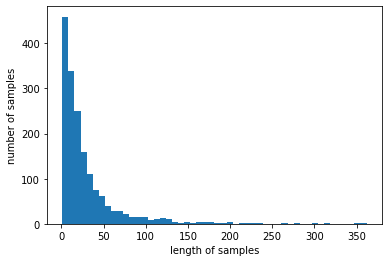

In [22]:
X_data = sequences
print('메일의 최대 길이 : %d' % max(len(l) for l in X_data))
print('메일의 평균 길이 : %f' % (sum(map(len, X_data))/len(X_data)))
plt.hist([len(s) for s in X_data], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [23]:
max_len = 362
# 전체 데이터셋의 길이는 max_len으로 맞춥니다.
data = pad_sequences(X_data, maxlen = max_len)
print("훈련 데이터의 크기(shape): ", data.shape)
X_test = data[n_of_train:] #X_data 데이터 중에서 뒤의 1034개의 데이터만 저장
y_test = np.array(y_data[n_of_train:]) #y_data 데이터 중에서 뒤의 1034개의 데이터만 저장
X_train = data[:n_of_train] #X_data 데이터 중에서 앞의 4135개의 데이터만 저장
y_train = np.array(y_data[:n_of_train]) #y_data 데이터 중에서 앞의 4135개의 데이터만 저장

훈련 데이터의 크기(shape):  (1697, 362)


In [24]:
from tensorflow.keras.layers import SimpleRNN, Embedding, Dense
from tensorflow.keras.models import Sequential

In [25]:
model = Sequential()
model.add(Embedding(vocab_size, 32)) # 임베딩 벡터의 차원은 32
model.add(SimpleRNN(32)) # RNN 셀의 hidden_size는 32
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=10, batch_size=5, validation_split=0.2)


Epoch 1/10
217/217 [==============================] - 37s 155ms/step - loss: 0.0162 - acc: 0.5216 - val_loss: 0.1197 - val_acc: 0.5000
Epoch 2/10
217/217 [==============================] - 33s 153ms/step - loss: -0.0103 - acc: 0.5266 - val_loss: 0.1437 - val_acc: 0.5000
Epoch 3/10
217/217 [==============================] - 33s 151ms/step - loss: -0.3979 - acc: 0.5228 - val_loss: 0.1479 - val_acc: 0.5000
Epoch 4/10
217/217 [==============================] - 33s 152ms/step - loss: -0.6241 - acc: 0.5164 - val_loss: 0.1714 - val_acc: 0.5037
Epoch 5/10
217/217 [==============================] - 33s 153ms/step - loss: -0.7519 - acc: 0.5189 - val_loss: 0.2153 - val_acc: 0.5000
Epoch 6/10
217/217 [==============================] - 33s 151ms/step - loss: -0.8220 - acc: 0.5814 - val_loss: 0.1659 - val_acc: 0.5147
Epoch 7/10
217/217 [==============================] - 33s 151ms/step - loss: -2.2601 - acc: 0.5742 - val_loss: 0.7646 - val_acc: 0.4743
Epoch 8/10
217/217 [=============================

In [26]:
print("\n 테스트 정확도: %.4f" % (model.evaluate(X_test, y_test)[1]))

11/11 [==============================] - 0s 20ms/step - loss: 1.0046 - acc: 0.5147

 테스트 정확도: 0.5147


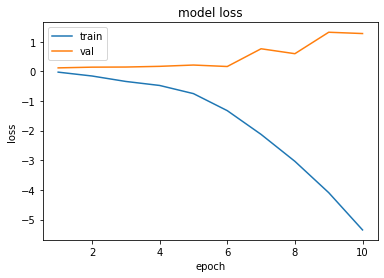

In [27]:
epochs = range(1, len(history.history['acc']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [28]:
! git clone https://github.com/seawavve/PeekABook

Cloning into 'PeekABook'...
remote: Enumerating objects: 192, done.
remote: Counting objects: 100% (192/192), done.
remote: Compressing objects: 100% (185/185), done.
remote: Total 192 (delta 98), reused 4 (delta 1), pack-reused 0
Receiving objects: 100% (192/192), 2.28 MiB | 11.58 MiB/s, done.
Resolving deltas: 100% (98/98), done.


In [33]:
! ls

PeekABook  Peterpan_emo3.csv  sample_data


In [32]:
! cd model
! git add .
! git commit -m "tensorflow_rnn_50"
! git push

/bin/bash: line 0: cd: model: No such file or directory
fatal: not a git repository (or any of the parent directories): .git
fatal: not a git repository (or any of the parent directories): .git
fatal: not a git repository (or any of the parent directories): .git
